**Importing & Configuring**

In [2]:
import math
import pandas as pd
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.table as tab
import matplotlib.transforms as trans
from matplotlib.text import OffsetFrom
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as mticker
import seaborn as sns
import os
import warnings
from scipy import stats
import pingouin as pg
import sys
from plotter.HeatMapPlotter import HeatMapPlotter 
from plotter.SpacePlotter import SpacePlotter 
from plotter.SignalPlotter import SignalPlotter 
from anytree import Node, RenderTree
from utils import *
from mystatspackage import statistics

# Get the current working directory
cwd = os.getcwd()
img_directory = 'img'
path_img_directory = os.path.join(cwd, img_directory)
filename_head = 'study1'
filename_extension = 'jpg'
figure_dpi = 300
# Ignore all warning for clean output
warnings.simplefilter("ignore")

In [3]:
pin_mass = 0.2 # pin mass in kg
pin_accel = 0.075 # robot speed in m/s²
pin_force = pin_accel * pin_mass
print("pin force: %s kg-m/s²" % pin_force)

Kh = 250 # human speed in mm/s -> 15mph (TO JUSTIFY)
Kr = 75 # robot speed in mm/s 
Tr = 0.100 # 50fps in precision mode + time for computation (TO MEASURE) - Reaction time to detect human and issue a stop – a parameter measured during timing test in s
Tb = 0.100 # Brake time in s (TO MEASURE)
B = 6.25 # brake distance in mm (150mm/24 steps)
C = 5 # 5mm accuracy of leap motion (TO MEASURE) CH + CR, the region surrounding the human and robot respectively. For the testbed, this region includes the uncertainty in position and dimension of each. 
S = Kh*(Tr + Tb) + (Kr * Tr) + B + C
print('Minimum separation distance: %smm' % S)

mass_hand =  1.3 #kg
max_pin_speed = 50 #mm/s
hand_speed = 6 #m/s
max_hand_speed = 170 #km/h
force_hand = (hand_speed/0.01) * mass_hand 
print("Max hand force = " + str(force_hand) + "N")
print(12.75/(force_hand + 12.75))



pin force: 0.015 kg-m/s²
Minimum separation distance: 68.75mm
Max hand force = 780.0N
0.01608325449385052


### Fetching dataframe

In [4]:
# Quantitative Dataframes
ROOT_NODE_NAME = "FACTORS"
INPUT_COLUMN_NAMES = [ 
    'Date', 'Participant', 'Task', 'Modality', 'Session', 'Trial' , 
    'Target_X', 'Target_Y',
    'SC_Duration', 'SC_Count_Mean', 'SC_Count_SD', 'SC_Count_Max', 'SC_Count_Min',
    'SC_Amplitude_Mean', 'SC_Amplitude_SD', 'SC_Amplitude_Max', 'SC_Amplitude_Min',
    # eda event-related features
    'EDA_Response_Count',
    'EDA_Response_Mean',
    'EDA_Response_SD',
    'EDA_Response_Max',
    'EDA_Response_Min',

    'EDA_Level_Mean',
    'EDA_Level_SD',
    'EDA_Level_Max',
    'EDA_Level_Min',

     # ppg event-related features
    'BVP_Peak_Count',
    'BVP_Peak_Mean',
    'BVP_Peak_SD',
    'BVP_Peak_Max',
    'BVP_Peak_Min',

    'BVP_Rate_Mean',
    'BVP_Rate_SD',
    'BVP_Rate_Max',
    'BVP_Rate_Min'
    ]
parse_directory = "parse"
quant_file = 'quantitative-description.csv'
df_quant = pd.read_csv(os.path.join(parse_directory, quant_file))
column_name_diff = list(set(df_quant.columns.values.tolist()) - set(INPUT_COLUMN_NAMES))
if len(column_name_diff) != 0:
    err("Missing columns (%s)" %column_name_diff)
    exit()
df_quant['Date'] = pd.to_datetime(df_quant['Date'])
if df_quant.index.duplicated(keep='first').sum(): print("{ERROR] duplicated indexes found!")

# for each participant get all combinations of task and modality

#df_quant.groupby(['Participant', 'Task', 'Modality']).size().reset_index(name='counts')

TASK_NAMES = ['USER', 'SYSTEM']
MODALITY_NAMES = ['SMS', 'SSM']
CONTROL_NAMES = ['SMS-REST', 'SSM-REST']

df_quant = df_quant.loc[~df_quant['Modality'].isin(CONTROL_NAMES), :]

# Qualitative Dataframes
data_directory = 'data'
form_directory = 'Forms/all'
demography_filename = "demography.xlsx"
demography_headers = ['DATE','AGE_TO_DELETE', 'SEXE', 'STUDY', 'AGE', 'COBOT', 'COBOT_TO_DELETE']
df_demography = pd.read_excel(os.path.join(data_directory,form_directory, demography_filename ), names=demography_headers)
df_demography = df_demography.drop(columns=['DATE', 'AGE_TO_DELETE', 'COBOT_TO_DELETE'])
df_demography = df_demography.drop(index=[0, 1, 2])
df_demography.reset_index(inplace=True, drop=True)

sequence_filename = 'sequence.xlsx'
stress_filename = "stress-and-safety.xlsx"
form_columns = ['session0', 'session1', 'session2', 'session3']
header_names = ['DATE', 'NOT_STRESSED⇔MAX_STRESSED', 'NERVOUS⇔RELAXED', 'CALM⇔AGITATED', 'SERENE⇔SURPRISED', 'SLOW⇔FAST', 'RIGID⇔FLUID', 'CALM⇔BRUTAL', 'PREDICTABLE⇔SURPRISING', 'SYNCHRONOUS⇔ASYNCHRONOUS']
df_qual = pd.read_excel(os.path.join(data_directory,form_directory, stress_filename ), names=header_names)

df_seq = pd.read_excel(sequence_filename, index_col=0)
participants_indexes = []
tasks_indexes = []
modalities_indexes = []

for index, row in df_qual.iterrows():
    session_index = int(index % 4)
    participant_index = int(index / 4)
    #print("%s:%s" %(participant_index, session_index))
    sequence_tag = df_seq.iloc[participant_index][session_index]
    task = sequence_tag.split('-')[0]
    modality = sequence_tag.split('-')[1]
    participants_indexes.append(participant_index)
    tasks_indexes.append(task)
    modalities_indexes.append(modality)
df_qual.insert(1, "Modality", modalities_indexes)
df_qual.insert(1, "Task", tasks_indexes)
df_qual.insert(1, "Participant", participants_indexes)

factor_values_labels_map = {
    'Task':{
        'values':['SYSTEM', 'USER'],
        'labels':['Trigger_{system}', 'Trigger_{user}'],
        },
    'Modality':{
        'values':['SSM', 'SMS'],
        'labels':['Strategy_{ssm}', 'Strategy_{sms}'],
        },
    'Target_Y':{
        'values':[1, 3, 5],
        'labels':['Level_{finger}', 'Level_{hand}', 'Level_{arm}'],
        }
}


# compute UEQ-S scores
#df_qual.loc[:, header_names[1::]] = df_qual.loc[:,header_names[1::]] - 3


## DEMOGRAPHY

In [5]:

demography_values_labels_map = {
    'SEXE':{
        'values':['Homme', 'Femme'],
        'labels':[0, 1],
        },
    'AGE': {
        'values':[ "%d ans" %x for x in range(100)],
        'labels':[x for x in range(100)],
       },
    'STUDY':{
        'values':["Sans diplôme", "Brevet des collèges", "CAP/BEP (autres diplômes techniques)", "Bac (général, professionnelle et technologique)", "Bac+2 (BTS ou autre)", "Bac+3/4 (Licence, Maîtrise)", "Bac+5 (Master, écoles d'ingénieurs, écoles d'arts...)", "Bac+8 (Doctorat)"],
        'labels':[0, 1, 2, 3, 4, 5, 6, 7],
        },
    'COBOT':{
        'values':["Je ne connais pas les robots collaboratifs (ou cobots)", "Jamais", "Rarement", "De temps en temps", "Souvent", "Toujours"],
        'labels':[0, 1, 2, 3, 4, 5],
        }
}
for column_name in demography_values_labels_map:
    values_labels_map = demography_values_labels_map[column_name]
    for column_value, column_label in zip(values_labels_map['values'], values_labels_map['labels']):
        df_demography.loc[:, column_name] = df_demography.loc[:, column_name].replace(column_value, column_label)

# descriptive statistics
desc_stats_of_interest = ['count', 'mean', 'median', 'mode']
df_stats_desc = statistics.Statistics.describePlus(df_demography).round(3)
display(df_stats_desc.loc[desc_stats_of_interest, :])

,SEXE,STUDY,AGE,COBOT
count,16.0,16.0,16.000,16.000
mean,0.5,6.0,34.438,0.812
median,0.5,6.0,31.500,1.000
mode,0.0,7.0,26.000,1.000


# PERCEIVED SAFETY QUESTIONNAIRE

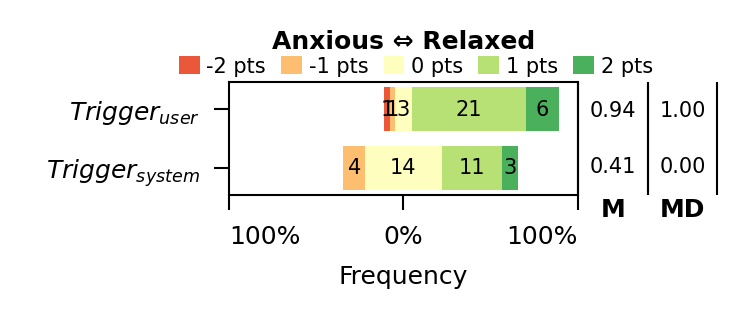

,USER,SYSTEM
count,32.000,32.000
mean,0.938,0.406
median,1.000,0.000
mode,1.000,0.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USER|SYSTEM,32,Wilcoxon,59.0,0.012,0.572464


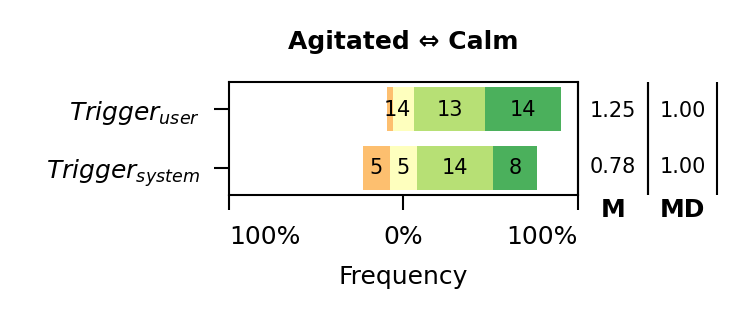

,USER,SYSTEM
count,32.00,32.000
mean,1.25,0.781
median,1.00,1.000
mode,2.00,1.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USER|SYSTEM,32,Wilcoxon,21.0,0.006,0.72549


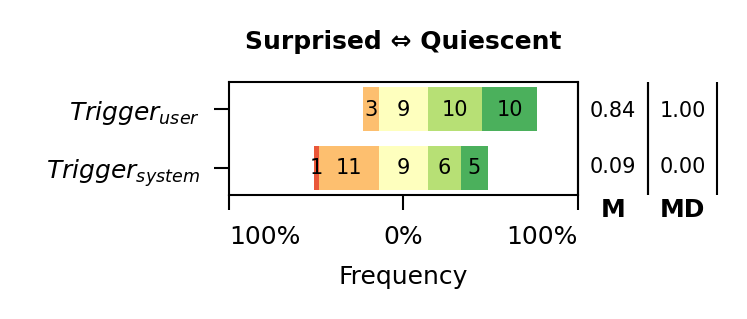

,USER,SYSTEM
count,32.000,32.000
mean,0.844,0.094
median,1.000,0.000
mode,2.000,-1.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USER|SYSTEM,32,Wilcoxon,56.0,0.006,0.626667


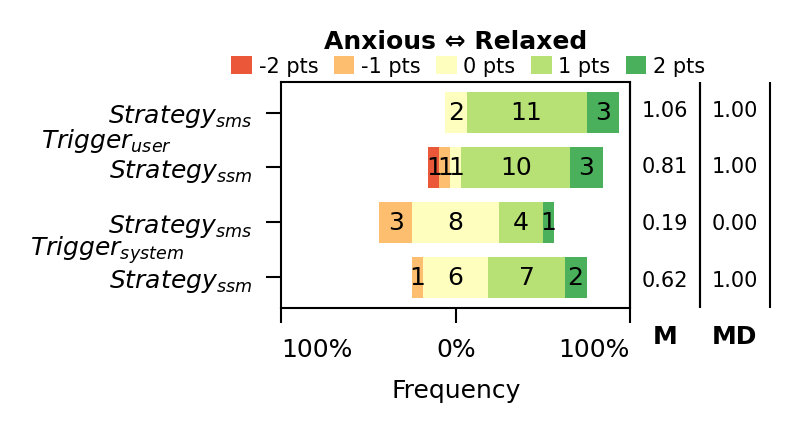

,USER-SMS,USER-SSM,SYSTEM-SMS,SYSTEM-SSM
count,16.000,16.000,16.000,16.000
mean,1.062,0.812,0.188,0.625
median,1.000,1.000,0.000,1.000
mode,1.000,1.000,0.000,1.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USER-SMS | USER-SSM | SYSTEM-SMS | SYSTEM-SSM,16,Friedman,16.111111,0.001076,0.335648
1,USER-SMS|USER-SSM,16,Wilcoxon,4.0,1.0,0.466667
2,USER-SMS|SYSTEM-SMS,16,Wilcoxon,0.0,0.004888,1.0
3,USER-SSM|SYSTEM-SSM,16,Wilcoxon,28.0,1.0,0.151515
4,SYSTEM-SMS|SYSTEM-SSM,16,Wilcoxon,4.0,0.167322,-0.777778


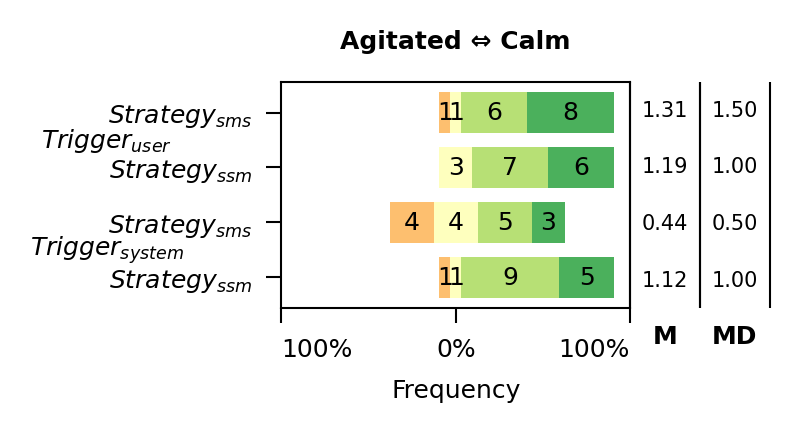

,USER-SMS,USER-SSM,SYSTEM-SMS,SYSTEM-SSM
count,16.000,16.000,16.000,16.000
mean,1.312,1.188,0.438,1.125
median,1.500,1.000,0.500,1.000
mode,2.000,1.000,1.000,1.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USER-SMS | USER-SSM | SYSTEM-SMS | SYSTEM-SSM,16,Friedman,16.078652,0.001093,0.334972
1,USER-SMS|USER-SSM,16,Wilcoxon,5.0,1.0,0.333333
2,USER-SMS|SYSTEM-SMS,16,Wilcoxon,0.0,0.029647,1.0
3,USER-SSM|SYSTEM-SSM,16,Wilcoxon,16.0,1.0,0.111111
4,SYSTEM-SMS|SYSTEM-SSM,16,Wilcoxon,0.0,0.04616,-1.0


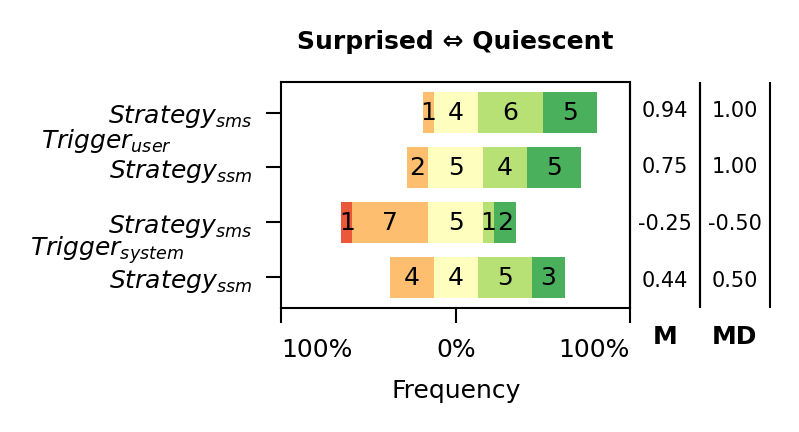

,USER-SMS,USER-SSM,SYSTEM-SMS,SYSTEM-SSM
count,16.000,16.00,16.00,16.000
mean,0.938,0.75,-0.25,0.438
median,1.000,1.00,-0.50,0.500
mode,1.000,0.00,-1.00,1.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USER-SMS | USER-SSM | SYSTEM-SMS | SYSTEM-SSM,16,Friedman,14.305785,0.002517,0.298037
1,USER-SMS|USER-SSM,16,Wilcoxon,12.0,1.0,0.333333
2,USER-SMS|SYSTEM-SMS,16,Wilcoxon,0.0,0.00811,1.0
3,USER-SSM|SYSTEM-SSM,16,Wilcoxon,37.0,1.0,0.186813
4,SYSTEM-SMS|SYSTEM-SSM,16,Wilcoxon,8.0,0.097031,-0.757576


In [6]:
PLOT_SAVING = True
from IPython.display import display, HTML

factor_names_list = [ ['Task'], ['Task', 'Modality']]  # ['All']]#, ['Modality']

variable_name_list = [ 'NERVOUS⇔RELAXED', 'CALM⇔AGITATED', 'SERENE⇔SURPRISED']

variable_range_list = [
    (1,5), (1,5), (1,5)
]

variable_legend_hide_list = [False, True, True]
variable_reverse_list = [False, True, True]

new_variable_name_list = [ 'Anxious ⇔ Relaxed', 'Agitated ⇔ Calm', 'Surprised ⇔ Quiescent']

new_variable_range_list = [
    (-2,2), (-2,2), (-2,2)
]

desc_stats_of_interest = ['count', 'mean', 'median', 'mode']

for factor_names in factor_names_list:
    for variable_index, variable_name in enumerate(variable_name_list):
        # generate a title
        variable_title = '[%s] %s' %(' x '.join(factor_names), new_variable_name_list[variable_index])
        display(HTML("<h1>%s</h1>" %(variable_title)))
        # fetch useful information
        variable_reverse = variable_reverse_list[variable_index]
        new_variable_name = new_variable_name_list[variable_index]
        (var_min, var_max) = variable_range_list[variable_index]
        (new_var_min, new_var_max) = new_variable_range_list[variable_index]
        if factor_names[0] != 'All':
            # scoping of global dataframe
            df_var = df_qual.loc[::,factor_names + [variable_name]].reset_index()
            # centering values and inversing them
            var_length = var_max - var_min
            new_var_length = new_var_max - new_var_min
            df_var_coeff =  1 - ((var_max - df_var.loc[:, variable_name])/var_length)
            df_var.loc[:, variable_name] = new_var_min + df_var_coeff * new_var_length
            if variable_reverse:
                df_var.loc[:, variable_name] = new_var_min + (1 - df_var_coeff) * new_var_length
            #print("%s => %s" %(' x '.join(factor_names), variable_name))
            # renaming columns 
            df_var_columns = {}
            for factor_index, factor_name in enumerate(factor_names):
                df_var_columns[factor_name] = "factor%s" % factor_index
            df_var_columns[variable_name] = "variable"
            df_var.rename(columns=df_var_columns, inplace=True)
            factor_columns = [factor_column for factor_column in df_var.columns.values if "factor" in factor_column]
            # plotting figure
            if len(factor_columns) == 1:
                fig_quant = statistics.Statistics.plotOrdinalMonoFactor(
                    df_var,
                    figure_size = (1.5, 0.5),
                    figure_dpi = 300,
                    legend_hide = variable_legend_hide_list[variable_index],
                    legend_bbox_anchor = (0.55, 1.14),
                    table_bbox = [1.00, -0.25, 0.4, 1.25],
                    table_head_height = 0.5,
                    table_row_height = 1,
                    table_column_width = 1,
                    table_head_size = 6,
                    table_cell_size = 5,
                    factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                    factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                    variable_column = 'variable',
                    variable_label = new_variable_name_list[variable_index],
                    variable_lim = new_variable_range_list[variable_index],
                    )
                if PLOT_SAVING:
                    filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                    fig_quant.savefig(os.path.join(path_img_directory, filename), bbox_inches='tight', dpi = 300)
                    plt.show()
            if len(factor_columns) == 2:
                fig_quant = statistics.Statistics.plotOrdinalDualFactors(
                    df_var,
                    figure_size = (1.5, 1),
                    figure_dpi = 300,
                    legend_hide = variable_legend_hide_list[variable_index],
                    legend_bbox_anchor = (0.55, 1.07),
                    table_bbox = [1.00, -0.25, 0.4, 1.25],
                    table_head_height = 1,
                    table_row_height = 1,
                    table_head_size = 6,
                    table_cell_size = 5,
                    factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                    factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                    factor2_columns = factor_values_labels_map[factor_names[1]]['values'],
                    factor2_labels = factor_values_labels_map[factor_names[1]]['labels'],
                    variable_column = 'variable',
                    variable_label = new_variable_name_list[variable_index],
                    variable_lim = new_variable_range_list[variable_index],
                    )
                if PLOT_SAVING:
                    filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                    fig_quant.savefig(os.path.join(path_img_directory, filename), bbox_inches='tight', dpi = 300)
                    # fetch variable dataframe
                    plt.show()
            
            
            # descriptive statistics
            
            # Pivot factor x variables
            
            df_var_cpy = df_var.copy()
            df_var_cpy["factor"] = df_var_cpy[factor_columns].apply("-".join, axis=1)
            df_var_cpy.drop(columns=factor_columns, inplace=True)
            multifactor_values = df_var_cpy["factor"].unique().tolist()
            df_var_pivot = df_var_cpy.pivot(index="index", columns="factor", values="variable")

            df_var_pivot = pd.DataFrame()
            for multifactor_value in multifactor_values:
                raw_values = df_var_cpy.loc[df_var_cpy['factor'] == multifactor_value, 'variable'].values
                df_var_col = pd.DataFrame({multifactor_value:raw_values})
                df_var_pivot = pd.concat([df_var_pivot,df_var_col],  axis=1)
                
            # descriptive statistics
            df_stats_desc = statistics.Statistics.describePlus(df_var_pivot).round(3)
            display(df_stats_desc.loc[desc_stats_of_interest, :])
            df_stats_infer = statistics.Statistics.inferQualOrdinalPaired(df_var_pivot, variable_range_list[variable_index]).round(3)
            display(df_stats_infer)
        else:
            df_var = df_qual.loc[::, [variable_name]]
            # centering values and inversing them
            var_length = var_max - var_min
            new_var_length = new_var_max - new_var_min
            df_var_coeff =  1 - ((var_max - df_var.loc[:, variable_name])/var_length)
            df_var.loc[:, variable_name] = new_var_min + df_var_coeff * new_var_length
            if variable_reverse:
                df_var.loc[:, variable_name] = new_var_min + (1 - df_var_coeff) * new_var_length
            print("%s => %s" %(' x '.join(factor_names), new_variable_name))
            df_stats_desc = statistics.Statistics.describePlus(df_var).round(3)
            display(df_stats_desc.loc[desc_stats_of_interest, :])



# PHYSIOLOGICAL SIGNALS

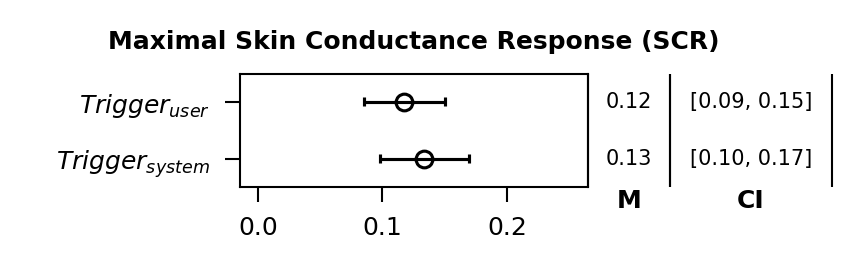

,SYSTEM,USER
count,252.000,272.000
mean,0.134,0.117
cil,0.100,0.090
cih,0.170,0.150


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,SYSTEM|USER,286,False,Wilcoxon,11571.0,0.007,0.199793


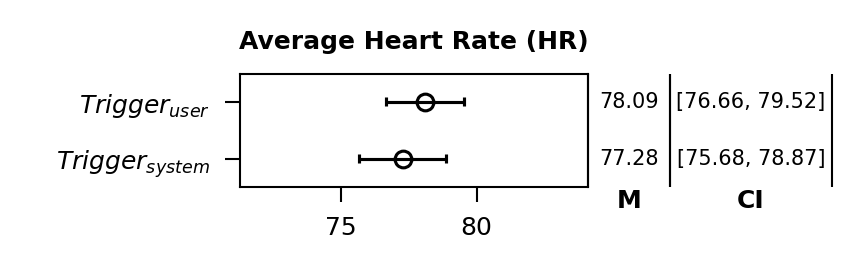

,SYSTEM,USER
count,274.000,286.000
mean,77.277,78.089
cil,75.620,76.600
cih,78.870,79.470


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,SYSTEM|USER,286,False,Wilcoxon,16332.0,0.056,-0.133006


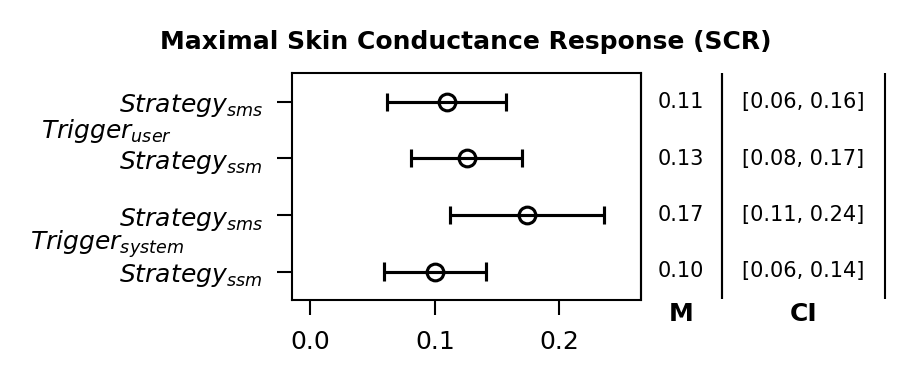

,SYSTEM-SMS,SYSTEM-SSM,USER-SMS,USER-SSM
count,114.000,138.00,138.00,134.000
mean,0.174,0.10,0.11,0.126
cil,0.120,0.06,0.07,0.080
cih,0.240,0.15,0.16,0.170


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,SYSTEM-SMS | SYSTEM-SSM | USER-SMS | USER-SSM,144,False,Friedman,11.292,0.010247,0.03764
1,SYSTEM-SMS|SYSTEM-SSM,144,False,Wilcoxon,2013.0,0.005122,0.352317
2,SYSTEM-SMS|USER-SMS,144,False,Wilcoxon,1854.0,0.002196,0.381485
3,SYSTEM-SSM|USER-SSM,144,False,Wilcoxon,3763.0,1.0,-0.102445
4,USER-SMS|USER-SSM,144,False,Wilcoxon,3625.0,0.567796,-0.148561


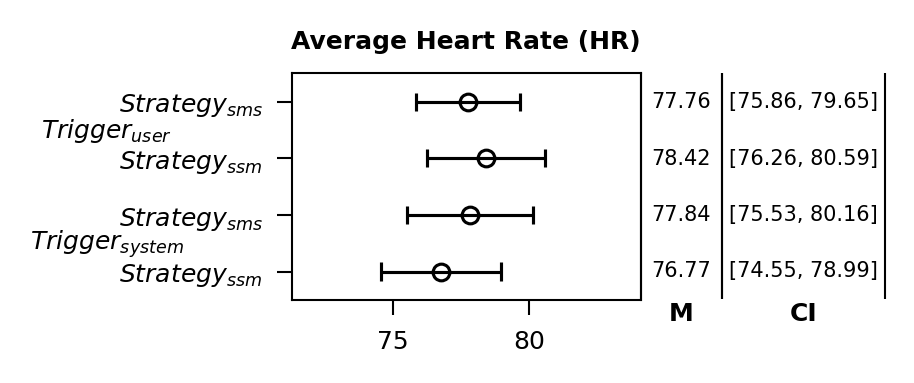

,SYSTEM-SMS,SYSTEM-SSM,USER-SMS,USER-SSM
count,130.000,144.000,144.000,142.000
mean,77.843,76.767,77.758,78.425
cil,75.440,74.500,75.870,76.190
cih,80.190,78.940,79.510,80.640


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,SYSTEM-SMS | SYSTEM-SSM | USER-SMS | USER-SSM,144,False,Friedman,2.667692,0.445746,0.00684
1,SYSTEM-SMS|SYSTEM-SSM,144,False,Wilcoxon,4101.0,1.0,-0.036759
2,SYSTEM-SMS|USER-SMS,144,False,Wilcoxon,3893.0,1.0,-0.085614
3,SYSTEM-SSM|USER-SSM,144,False,Wilcoxon,4471.0,0.87173,-0.119275
4,USER-SMS|USER-SSM,144,False,Wilcoxon,4931.0,1.0,-0.028661


In [7]:
PLOT_SAVING = True
from IPython.display import display, HTML
# Compute UEQ-S 

factor_names_list = [['Task'], ['Task', 'Modality']] #
variable_name_list = ['EDA_Response_Max', 'BVP_Rate_Mean']
new_variable_name_list = ['Maximal Skin Conductance Response (SCR)', 'Average Heart Rate (HR)']
filename_body_list = ['Maximal Skin Conductance Response', 'Average Heart Rate']
desc_stats_of_interest = ['count', 'mean', 'cil', 'cih']

for factor_names in factor_names_list:
    for variable_index, variable_name in enumerate(variable_name_list):
        # generate a title
        variable_title = '[%s] %s' %(' x '.join(factor_names), filename_body_list[variable_index])
        display(HTML("<h1>%s</h1>" %(variable_title)))
        # scope dataframe
        df_var = df_quant.loc[::,factor_names + [variable_name]].reset_index()
        # renaming columns 
        df_var_columns = {}
        for factor_index, factor_name in enumerate(factor_names):
            df_var_columns[factor_name] = "factor%s" % factor_index
        df_var_columns[variable_name] = "variable"
        df_var.rename(columns=df_var_columns, inplace=True)
        factor_columns = [factor_column for factor_column in df_var.columns.values if "factor" in factor_column]
        # # plotting figure
        # if len(factor_columns) == 1:
        #     fig_quant = statistics.Statistics.plotOrdinalMonoFactor(
        #         df_var,
        #         figure_size = (2, 1),
        #         figure_dpi = 300,
        #         factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
        #         factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
        #         variable_column = 'variable',
        #         variable_label = new_variable_name_list[variable_index],
        #         variable_lim = new_variable_range_list[variable_index],
        #         )
        #     plt.show()

        if len(factor_columns) == 1:
            fig_quant = statistics.Statistics.plotQuantMonoFactor(
                df_var,
                figure_size = (1.5, 0.5),
                figure_dpi = 300,
                table_bbox = [1.0, -0.25, 0.7, 1.25],
                table_head_size = 6,
                table_cell_size = 5,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                df_benchmark = None
            )
            if PLOT_SAVING:
                filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                fig_quant.savefig(os.path.join(path_img_directory, filename), bbox_inches='tight', dpi = 300)
            plt.show()

        if len(factor_columns) == 2:
            fig_quant = statistics.Statistics.plotQuantDualFactors(
                df_var,
                figure_size = (1.5, 1),
                figure_dpi = 300,
                table_bbox = [1.0, -0.12, 0.7, 1.12],
                table_head_height = 0.5,
                table_row_height = 1,
                table_head_size = 6,
                table_cell_size = 5,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                factor2_columns = factor_values_labels_map[factor_names[1]]['values'],
                factor2_labels = factor_values_labels_map[factor_names[1]]['labels'],
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                df_benchmark = None
                )
            if PLOT_SAVING:
                filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                fig_quant.savefig(os.path.join(path_img_directory, filename), bbox_inches='tight', dpi = 300)
            plt.show()
        
        # descriptive statistics
        
        # Pivot factor x variables
        df_var_cpy = df_var.copy()
        df_var_cpy["factor"] = df_var_cpy[factor_columns].apply(lambda x: "-".join([str(_) for _ in x]), axis=1)
        df_var_cpy.drop(columns=factor_columns, inplace=True)
        multifactor_values = df_var_cpy["factor"].unique().tolist()
        df_var_pivot = df_var_cpy.pivot(index="index", columns="factor", values="variable")

        df_var_pivot = pd.DataFrame()
        for multifactor_value in multifactor_values:
            raw_values = df_var_cpy.loc[df_var_cpy['factor'] == multifactor_value, 'variable'].values
            df_var_col = pd.DataFrame({multifactor_value:raw_values})
            df_var_pivot = pd.concat([df_var_pivot,df_var_col],  axis=1)
            
        # descriptive statistics
        df_stats_desc = statistics.Statistics.describePlus(df_var_pivot).round(3)
        display(df_stats_desc.loc[desc_stats_of_interest, ::])
        
        df_stats_infer = statistics.Statistics.inferQuantPaired(df_var_pivot, normality_assumption = 'false').round(3)
        display(df_stats_infer)



('SYSTEM', 'SMS')

,index,Task,Modality,Sequence,EDA_Response_Max
0,1,SYSTEM,SMS,16,0.005222
1,2,SYSTEM,SMS,17,0.005031
2,3,SYSTEM,SMS,18,0.003939
3,4,SYSTEM,SMS,19,0.005166
4,5,SYSTEM,SMS,20,0.004834
...,...,...,...,...,...
537,598,SYSTEM,SMS,4,0.390702
538,599,SYSTEM,SMS,5,NaN
539,600,SYSTEM,SMS,6,0.242195
540,601,SYSTEM,SMS,7,0.011385


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.200747,0.058903,3.408105,0.000910,0.002561,-0.006345,0.084039,0.317455
1,Sequence,-0.001770,0.003301,-0.536267,0.592837,0.002561,-0.006345,-0.008310,0.004770


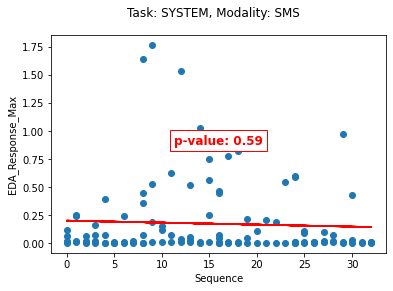

('SYSTEM', 'SSM')

,index,Task,Modality,Sequence,EDA_Response_Max
9,11,SYSTEM,SSM,24,0.004080
10,12,SYSTEM,SSM,25,0.004769
11,13,SYSTEM,SSM,26,0.004783
12,14,SYSTEM,SSM,27,0.004783
13,15,SYSTEM,SSM,28,0.023832
...,...,...,...,...,...
546,608,SYSTEM,SSM,12,0.212111
547,609,SYSTEM,SSM,13,0.154059
548,610,SYSTEM,SSM,14,0.030479
549,611,SYSTEM,SSM,15,0.005736


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.221510,0.039993,5.538705,1.520431e-07,0.082561,0.075815,0.142421,0.300599
1,Sequence,-0.007549,0.002158,-3.498391,6.330090e-04,0.082561,0.075815,-0.011817,-0.003282


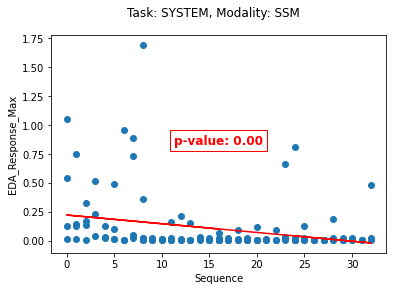

('USER', 'SMS')

,index,Task,Modality,Sequence,EDA_Response_Max
18,21,USER,SMS,0,0.020184
19,22,USER,SMS,1,0.004970
20,23,USER,SMS,2,0.004884
21,24,USER,SMS,3,0.004854
22,25,USER,SMS,4,0.005029
...,...,...,...,...,...
555,618,USER,SMS,28,0.795388
556,619,USER,SMS,29,0.287593
557,620,USER,SMS,30,0.035539
558,621,USER,SMS,31,0.298725


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.040519,0.047363,0.855501,0.393779,0.020663,0.013462,-0.053145,0.134184
1,Sequence,0.004331,0.002556,1.693964,0.092561,0.020663,0.013462,-0.000725,0.009386


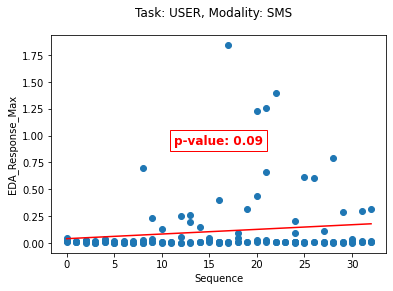

('USER', 'SSM')

,index,Task,Modality,Sequence,EDA_Response_Max
27,31,USER,SSM,8,0.004445
28,32,USER,SSM,9,0.004292
29,33,USER,SSM,10,0.005088
30,34,USER,SSM,11,0.005021
31,35,USER,SSM,12,0.004067
...,...,...,...,...,...
564,628,USER,SSM,20,0.526817
565,629,USER,SSM,21,0.003371
566,630,USER,SSM,22,0.061455
567,631,USER,SSM,23,0.335645


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.126771,0.043879,2.889077,0.004518,0.000007,-0.007568,0.039973,0.213569
1,Sequence,-0.000074,0.002367,-0.031072,0.975259,0.000007,-0.007568,-0.004757,0.004609


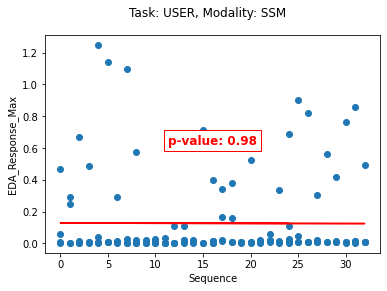

('SYSTEM', 'SMS')

,index,Task,Modality,Sequence,BVP_Rate_Mean
0,1,SYSTEM,SMS,16,73.738985
1,2,SYSTEM,SMS,17,71.495796
2,3,SYSTEM,SMS,18,70.894489
3,4,SYSTEM,SMS,19,71.912689
4,5,SYSTEM,SMS,20,70.865238
...,...,...,...,...,...
537,598,SYSTEM,SMS,4,82.293506
538,599,SYSTEM,SMS,5,82.958924
539,600,SYSTEM,SMS,6,84.895962
540,601,SYSTEM,SMS,7,83.892874


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,73.620797,2.233520,32.961788,2.146573e-64,0.036653,0.029127,69.201397,78.040197
1,Sequence,0.275519,0.124849,2.206822,2.910948e-02,0.036653,0.029127,0.028484,0.522553


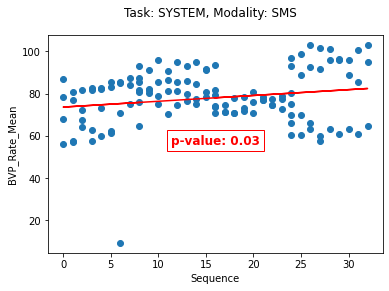

('SYSTEM', 'SSM')

,index,Task,Modality,Sequence,BVP_Rate_Mean
9,11,SYSTEM,SSM,24,75.841643
10,12,SYSTEM,SSM,25,69.899867
11,13,SYSTEM,SSM,26,71.063062
12,14,SYSTEM,SSM,27,77.388544
13,15,SYSTEM,SSM,28,71.007822
...,...,...,...,...,...
546,608,SYSTEM,SSM,12,82.032660
547,609,SYSTEM,SSM,13,78.290487
548,610,SYSTEM,SSM,14,82.256869
549,611,SYSTEM,SSM,15,84.627379


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,84.996724,2.094691,40.577206,5.349658e-80,0.127027,0.12088,80.855915,89.137533
1,Sequence,-0.514371,0.113158,-4.545613,1.162541e-05,0.127027,0.12088,-0.738063,-0.290680


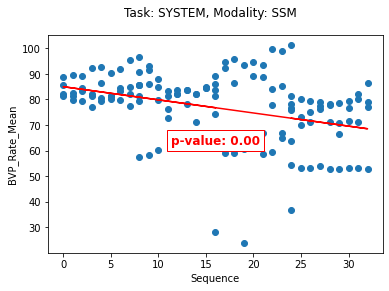

('USER', 'SMS')

,index,Task,Modality,Sequence,BVP_Rate_Mean
18,21,USER,SMS,0,62.875539
19,22,USER,SMS,1,75.560066
20,23,USER,SMS,2,80.480411
21,24,USER,SMS,3,68.088799
22,25,USER,SMS,4,63.909167
...,...,...,...,...,...
555,618,USER,SMS,28,86.077494
556,619,USER,SMS,29,86.307699
557,620,USER,SMS,30,85.407423
558,621,USER,SMS,31,85.923058


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,69.480019,1.736546,40.010463,3.360924e-79,0.176396,0.170596,66.047195,72.912842
1,Sequence,0.517345,0.093810,5.514798,1.602086e-07,0.176396,0.170596,0.331900,0.702790


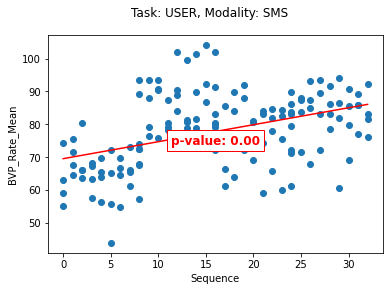

('USER', 'SSM')

,index,Task,Modality,Sequence,BVP_Rate_Mean
27,31,USER,SSM,8,76.793975
28,32,USER,SSM,9,73.298261
29,33,USER,SSM,10,75.894159
30,34,USER,SSM,11,73.138877
31,35,USER,SSM,12,73.331393
...,...,...,...,...,...
564,628,USER,SSM,20,88.987860
565,629,USER,SSM,21,85.200504
566,630,USER,SSM,22,82.879887
567,631,USER,SSM,23,82.497021


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,78.594022,2.170478,36.210470,5.726585e-73,0.000058,-0.007084,74.302871,82.885173
1,Sequence,-0.010568,0.117006,-0.090323,9.281595e-01,0.000058,-0.007084,-0.241896,0.220759


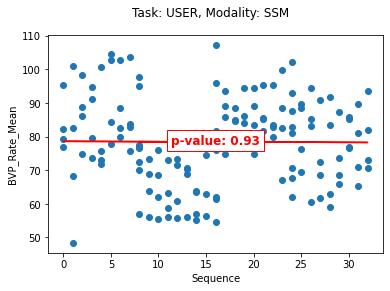

In [34]:

PLOT_SAVING = True
from IPython.display import display, HTML
# Compute UEQ-S 

factor_names_list = [['Task', 'Modality']] #
variable_name_list = ['EDA_Response_Max', 'BVP_Rate_Mean']
new_variable_name_list = ['Maximal Skin Conductance Response (SCR)', 'Average Heart Rate (HR)']
filename_body_list = ['Maximal Skin Conductance Response', 'Average Heart Rate']
desc_stats_of_interest = ['count', 'mean', 'cil', 'cih']

df_quant['Sequence'] = df_quant['Session'] * df_quant['Trial'].max() + df_quant['Trial']
for variable_index, variable_name in enumerate(variable_name_list):
    # generate a title
    variable_title = '[%s] %s' %(' x '.join(factor_names), filename_body_list[variable_index])
    display(HTML("<h1>%s</h1>" %(variable_title)))
    # scope dataframe
    df_var = df_quant.loc[::,factor_names + ["Sequence", variable_name]].reset_index()
    grouped = grouped = df_var.groupby(factor_names)
    for name, group in grouped:
        display(name, group)
        # group.boxplot(column=[variable_name], by="Sequence")
        # plt.show()
        x = group['Sequence']
        y = group[variable_name]
        x = x[(~x.isna() & ~y.isna())]
        y = y[(~x.isna() & ~y.isna())]
        # res = stats.linregress(x,y)
        # print(res)
        fig, ax = plt.subplots( nrows=1, ncols=1 )
        # add title to subplot

        fig.suptitle("Task: %s, Modality: %s" %(name[0], name[1]))
        ax.set_xlabel("Sequence")
        ax.set_ylabel(variable_name)
        ax.scatter(x, y)
        lm = pg.linear_regression(x, y, remove_na=True)
        display(lm)
        Y = lm['coef'][1] * x + lm['coef'][0]
        ax.plot(x, Y, color='red')
        # add p value to plot
        p_value = lm['pval'][1]
        ax.text(0.5, 0.5, "p-value: %.2f" %p_value, 
                 fontsize=12, 
                 transform=plt.gca().transAxes,
                 horizontalalignment='center',
                 weight="bold", color='red',
                 bbox=dict(facecolor='white', edgecolor='red'))
        
        if PLOT_SAVING:
            filename = filename_head + f'-learning_rate-variable_{variable_name}-task_{name[0]}-modality_{name[1]}.' + filename_extension
            fig.savefig(os.path.join(path_img_directory, filename), bbox_inches='tight', dpi = 300)
        plt.show()
    
        
# df_quant_participant_grouped = df_quant.groupby('Participant')
# for participant_group_name, df_participant_group in df_quant_participant_grouped:
#     print("\n-- Group with {} rows(s)".format(len(df_participant_group)))
#     print('CREATE TABLE {}('.format(participant_group_name))
#     df_participant_group = df_participant_group.sort_values(by=['Session', 'Trial'])
#     print(df_participant_group)

# for factor_names in factor_names_list:
#     for variable_index, variable_name in enumerate(variable_name_list):
#         # generate a title
#         variable_title = '[%s] %s' %(' x '.join(factor_names), filename_body_list[variable_index])
#         display(HTML("<h1>%s</h1>" %(variable_title)))
#         # scope dataframe
#         df_var = df_quant.loc[::,factor_names + ["Trial", variable_name]].reset_index()
#         grouped = grouped = df_var.groupby(factor_names)
#         for name, group in grouped:
#             display(name, group)
#             group.boxplot(column=[variable_name], by="Trial")
#             plt.show()



#df_quant.plot.scatter(x='Trial', y='EDA_Response_Max', c='DarkBlue')
#df_quant.boxplot(column=["EDA_Response_Max"], by="Trial")

**Fetching data**

In [ ]:
PLOT_SAVING = False
from IPython.display import display, HTML
# Compute UEQ-S 

factor_names_list = [['Task'], ['Modality'],  ['Task', 'Modality']]
variable_name_list = ['EDA_Response_Max', 'BVP_Rate_Mean', 'BVP_Rate_Max']
new_variable_name_list = ['Maximal Skin Conductance Response (SCR)', 'Average Heart Rate (HR)', 'Maximum Heart Rate (HR)']
filename_body_list = ['Maximal Skin Conductance Response', 'Average Heart Rate', 'Maximum Heart Rate']
desc_stats_of_interest = ['count', 'mean', 'cil', 'cih']

for factor_names in factor_names_list:
    for variable_index, variable_name in enumerate(variable_name_list):
        # generate a title
        variable_title = '[%s] %s' %(' x '.join(factor_names), filename_body_list[variable_index])
        display(HTML("<h1>%s</h1>" %(variable_title)))
        # scope dataframe
        df_var = df_quant.loc[::,factor_names + [variable_name]].reset_index()
        # renaming columns 
        df_var_columns = {}
        for factor_index, factor_name in enumerate(factor_names):
            df_var_columns[factor_name] = "factor%s" % factor_index
        df_var_columns[variable_name] = "variable"
        df_var.rename(columns=df_var_columns, inplace=True)
        factor_columns = [factor_column for factor_column in df_var.columns.values if "factor" in factor_column]
        # # plotting figure
        # if len(factor_columns) == 1:
        #     fig_quant = statistics.Statistics.plotOrdinalMonoFactor(
        #         df_var,
        #         figure_size = (2, 1),
        #         figure_dpi = 300,
        #         factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
        #         factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
        #         variable_column = 'variable',
        #         variable_label = new_variable_name_list[variable_index],
        #         variable_lim = new_variable_range_list[variable_index],
        #         )
        #     plt.show()

        if len(factor_columns) == 1:
            fig_quant = statistics.Statistics.plotQuantMonoFactor(
                df_var,
                figure_size = (1, 1),
                figure_dpi = 300,
                table_bbox = [1.0, -0.25, 0.85, 1.25],
                table_head_height = 0.5,
                table_row_height = 1,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                df_benchmark = None
                )
            if PLOT_SAVING:
                filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
            plt.show()

        if len(factor_columns) == 2:
            fig_quant = statistics.Statistics.plotQuantDualFactors(
                df_var,
                figure_size = (1, 1),
                figure_dpi = 300,
                table_bbox = [1.0, -0.12, 0.85, 1.12],
                table_head_height = 0.5,
                table_row_height = 1,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                factor2_columns = factor_values_labels_map[factor_names[1]]['values'],
                factor2_labels = factor_values_labels_map[factor_names[1]]['labels'],
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                df_benchmark = None
                )
            if PLOT_SAVING:
                filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
            plt.show()
        
        # descriptive statistics
        
        # Pivot factor x variables

        df_var_cpy = df_var.copy()
        df_var_cpy["factor"] = df_var_cpy[factor_columns].apply(lambda x: "-".join([str(_) for _ in x]), axis=1)
        df_var_cpy.drop(columns=factor_columns, inplace=True)
        multifactor_values = df_var_cpy["factor"].unique().tolist()
        df_var_pivot = df_var_cpy.pivot(index="index", columns="factor", values="variable")

        df_var_pivot = pd.DataFrame()
        for multifactor_value in multifactor_values:
            raw_values = df_var_cpy.loc[df_var_cpy['factor'] == multifactor_value, 'variable'].values
            df_var_col = pd.DataFrame({multifactor_value:raw_values})
            df_var_pivot = pd.concat([df_var_pivot,df_var_col],  axis=1)
            
        # descriptive statistics
        df_stats_desc = statistics.Statistics.describePlus(df_var_pivot).round(3)
        display(df_stats_desc.loc[desc_stats_of_interest, ::])
        
        df_stats_infer = statistics.Statistics.inferQuantPaired(df_var_pivot, normality_assumption = 'false').round(3)
        display(df_stats_infer)

In [ ]:
PLOT_SAVING = True

factors_names = [['Task', 'Modality', 'Target_Y']]
factors_labels = [['Task', 'Modality', 'Level']]
factors_types = [[str, str, int]]

task_values = ['SYSTEM', 'USER']
task_labels = ['Control_{system}', 'Control_{user}']
modality_values = ['SMS', 'SSM']
modality_labels = ['Mode_{sms}', 'Mode_{ssm}']

variable_values = ['EDA_Response_Max', 'BVP_Rate_Mean']
variable_labels = ['Maximal Skin Conductance Response (SCR)', 'Average Heart Rate (HR)']
desc_stats_of_interest = ['count', 'mean', 'cil', 'cih']

filename_head = 'study1'
filename_bodies = ['scr', 'hr']
filename_extension = 'jpg'

for variable_index, variable_value  in enumerate(variable_values):
    # fetch variable dataframe
    df_variable = df_quant.loc[::, ['Task', 'Modality', variable_value]]
    var_max_value = df_variable[variable_value].max()
    var_min_value = df_variable[variable_value].min()
    var_mean_value = df_variable[variable_value].mean()
    var_std_value = df_variable[variable_value].std()
    y_min = -0.5
    y_max = ( len(task_values) * len(modality_values) - 1) + 0.5
    y_range = y_max-y_min
    sigma_steps = 0.5
    x_min = var_mean_value - sigma_steps * var_std_value
    x_max =var_mean_value + sigma_steps * var_std_value
    x_range = x_max-x_min
    # create figure
    offset_fraction = 0.53
    axis_label_size = 6
    fig_title_size = 6
    variable_mean_dot_size = 4
    axis_line_width = 0.5
    variable_line_width = 0.75
    variable_ci_vline_offset = 0.15
    table_head_size = 5
    table_cell_size = 4
    w = 1.5
    h = 1
    d = 300
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(w,h), dpi=d) 

    #fig = plt.figure(figsize=(w,h), dpi=d) 
    #ax = plt.axes()
    axes.set_xlim([x_min, x_max])
    axes.set_ylim([y_min, y_max])
    y_ticklabels = []
    table_data = [['M', 'CI']]
    #ax.plot(x, y, "k")
    for task_index, task_value in enumerate(task_values):
        for modality_index, modality_value in enumerate(modality_values):
            # fetch Factor x Task
            df_task_modality = df_variable.loc[(df_variable['Task'] == task_value) & (df_variable['Modality'] == modality_value),::]
            # compute mean and 95% confidence interval of variable
            variable_clean = df_task_modality.loc[~np.isnan(df_task_modality[variable_value]), variable_value]
            variable_mean = variable_clean.mean()
            #variable_ci = pg.compute_bootci(variable_clean,func='mean')
            variable_ci = stats.t.interval(alpha=0.95, df=len(variable_clean)-1, loc=np.mean(variable_clean), scale=stats.sem(variable_clean)) 
            #variable_ci = stats.norm.interval(alpha=0.95, loc=np.mean(variable_clean), scale=stats.sem(variable_clean)) 
            # fill stats dataframe
            # plot features
            i = task_index * len(modality_values) + modality_index
            #tick_label = r"${0} \times {1}$".format(task_labels[task_index], modality_labels[modality_index])
            tick_label = r"${0}$".format(modality_labels[modality_index], variable_mean, variable_ci[0], variable_ci[1]) # + "\n" + "%0.2f [%0.2f, %0.2f]" %(variable_mean, variable_ci[0], variable_ci[1]) 
            y_ticklabels.append(tick_label)
            table_data.append(["%0.2f" %variable_mean, "[%0.2f, %0.2f]" %(variable_ci[0], variable_ci[1])])
            # axes.annotate("%0.2f [%0.2f, %0.2f]" %(variable_mean, variable_ci[0], variable_ci[1]) ,
            #     xy=(0, i), 
            #     xycoords='data',
            #     xytext=(-25, -axis_label_size), 
            #     textcoords='offset points',
            #     horizontalalignment='center',
            #     verticalalignment='center',
            #     fontsize=4,
            #     arrowprops=None #dict(arrowstyle="->", color='black')
            # )
            # ax.scatter(
            #     x=df_task_modality[variable_value].values, 
            #     y=[i-0.25 for _ in range(len(df_task_modality[variable_value].values))],
            #     c=[0.5,0.5,0.5],
            #     s=1
            # )
            axes.plot(variable_mean, i, 'o', markersize=variable_mean_dot_size, markerfacecolor='white', markeredgecolor='black', markeredgewidth=variable_line_width) 
            # ax.annotate("%.2f" %variable_mean,
            # xy=(variable_mean, i), 
            # xycoords='data',
            # xytext=(0, variable_mean_dot_size/2.0 + variable_line_width + 1), 
            # textcoords='offset points',
            # horizontalalignment='center',
            # verticalalignment='center',
            # fontsize=4,
            # arrowprops=None
            # )
            axes.hlines(i, variable_ci[0], variable_ci[1], colors='black', linestyles='solid', linewidth=variable_line_width)
            axes.vlines(variable_ci[0], i-variable_ci_vline_offset, i+variable_ci_vline_offset, colors='black', linestyles='solid', linewidth=variable_line_width)
            axes.vlines(variable_ci[1], i-variable_ci_vline_offset, i+variable_ci_vline_offset, colors='black', linestyles='solid', linewidth=variable_line_width)

            # ax.annotate("%.2f" %variable_ci[0],
            # xy=(variable_ci[0], i), 
            # xycoords='data',
            # xytext=(-variable_line_width, 0), 
            # textcoords='offset points',
            # horizontalalignment='right',
            # verticalalignment='center',
            # fontsize=4,
            # arrowprops=None #dict(arrowstyle="->", color='black')
            # )
            
            # ax.annotate("%.2f" %variable_ci[1],
            # xy=(variable_ci[1], i), 
            # xycoords='data',
            # xytext=(variable_line_width, 0), 
            # textcoords='offset points',
            # horizontalalignment='left',
            # verticalalignment='center',
            # fontsize=4,
            # arrowprops=None #dict(arrowstyle="->", color='black')
            # )

            axes.barh(y=i, width=0.1, height=variable_ci, left=0, color='white') 

        axes.text(
            x = x_min - offset_fraction * x_range, 
            y = (len(modality_values) - 1)/2 + task_index * len(modality_values),
            ha = 'center',
            va = 'center',
            fontsize=axis_label_size,
            s = r"${0}$".format(task_labels[task_index])
        )
    axes.set_yticks(range(len(y_ticklabels)))  
    axes.set_yticklabels(y_ticklabels)
    
    plt.title(variable_labels[variable_index], fontsize=fig_title_size, fontweight='bold')
    axes.tick_params(axis='y', labelsize=axis_label_size)
    axes.tick_params(axis='x', labelsize=axis_label_size)
    #axes.spines['right'].set_visible(False)
    #axes.spines['top'].set_visible(False)
    # change axes and ticks width
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(axis_line_width)
    axes.xaxis.set_tick_params(width=axis_line_width)
    axes.yaxis.set_tick_params(width=axis_line_width)
    # draw table
    axes_table = tab.Table(
        axes,
        bbox = [1.0, -0.25, 0.6, 1.25],
        #loc=trans.Bbox([[0, 1], [1, 7]]) #trans.Bbox.from_extents(x_max, y_max, 3, 7)
        )
        
    axes_table.auto_set_font_size(False)
    visible_edges_value = "open"
    nb_row = len(table_data)
    nb_col = len(table_data[0])
    for row_index, row_values in enumerate(table_data):
            for col_index, col_value in enumerate(row_values):
                col_width = 0.5 if col_index == 0 else 1
                if row_index == 0:
                        cell = axes_table.add_cell(
                            row= (nb_row - 1) - row_index,
                            col= col_index, 
                            width=col_width,
                            height=0.2,
                            edgecolor='k',
                            facecolor='w',
                            fill=False,
                            text=col_value,
                            loc='center',
                            fontproperties=FontProperties(size=table_head_size, weight='bold')
                        )
                        # if col_index == 0:
                        #     cell.visible_edges = "LTB"
                        # if col_index == nb_col - 1:
                        #     cell.visible_edges = "RTB"
                        cell.visible_edges = "open"
                        cell.set(linewidth=axis_line_width)
                else:
                    cell = axes_table.add_cell(
                            row= (nb_row - 1) - row_index,
                            col=col_index, 
                            width=col_width,
                            height=0.2,
                            edgecolor='k',
                            facecolor='w',
                            fill=False,
                            text=col_value,
                            loc='center',
                            fontproperties=FontProperties(size=table_cell_size)
                        )
                    # if col_index == 0:
                    #     cell.visible_edges = "LTB"
                    # if col_index == nb_col - 1:
                    #     cell.visible_edges = "RTB"
                    cell.visible_edges = "LR"
                    cell.set(linewidth=axis_line_width)
   
    axes.add_table(axes_table)
    # axes_table = plt.table( cellText=table_data,
    #                   rowLabels=["0", "1", "2", "3"],
    #                   rowColours=["blue", "blue","blue","blue"],
    #                   colLabels=["M", "CI_L", "CI_H"],
    #                   loc="right"
    #             )
    if PLOT_SAVING:
        filename = filename_head + '-' + filename_bodies[variable_index] + '.' + filename_extension
        fig.savefig(, bbox_inches='tight', dpi = 300)
    plt.show()
    # compute statistic
    df_variable['Task'] = df_variable['Task'] + '-' + df_variable['Modality']
    df_variable.drop(columns=['Modality'], inplace=True)
    df_variable.rename(columns={'Task':'Factor', variable_value:'Variable'}, inplace=True)
    df_variable_columns = df_variable['Factor'].unique()
    df_variable_pivot = pd.DataFrame()
    for df_variable_column in df_variable_columns:
        raw_values = df_variable.loc[df_variable['Factor'] == df_variable_column, 'Variable'].values
        df_var_col = pd.DataFrame({df_variable_column:raw_values})
        df_variable_pivot = pd.concat([df_variable_pivot,df_var_col],  axis=1)
    df_stats_desc = statistics.Statistics.describePlus(df_variable_pivot).round(2)
    display(df_stats_desc.loc[desc_stats_of_interest, ::])
    df_stats_infer = statistics.Statistics.inferQuantPaired(df_variable_pivot).round(3)
    display(df_stats_infer)


In [ ]:
import seaborn as sns

import matplotlib.ticker as mticker

PLOT_SAVING = True

task_values = ['SYSTEM', 'USER']
task_labels = ['Control_{system}', 'Control_{user}']
modality_values = ['SMS', 'SSM']
modality_labels = ['Mode_{sms}', 'Mode_{ssm}']

variable_values = [ 'NERVOUS⇔RELAXED', 'CALM⇔AGITATED', 'SERENE⇔SURPRISED']
variable_reverses = [False, True, True]
variable_labels = [ 'Anxious ⇔ Relaxed', 'Agitated ⇔ Calm', 'Surprised ⇔ Quiescent']
desc_stats_of_interest = ['count', 'median', 'mode', 'freq']
filename_head = 'study1'
filename_bodies = ['relaxation', 'agitation', 'surprise']
filename_extension = 'jpg'

stats_df = pd.DataFrame(columns = ['median'])
float_precision = 2

for variable_index, variable_value  in enumerate(variable_values):
    # fetch variable dataframe with value range between 1 and 5
    df_variable = df_qual.loc[::, ['Task', 'Modality', variable_value]]
    # set value range between 0 and 4
    df_variable[variable_value] -= 1
    # reverse values if required
    var_min = -2
    var_max = 2
    var_range = var_max - var_min
    var_range_list = range(var_min, var_max + 1)
    if variable_reverses[variable_index]:
        df_variable[variable_value] = var_range - df_variable[variable_value] 
    # set value range between -2 and 2
    df_variable[variable_value] += var_min

    x_min = -100
    x_max = 100
    x_range = x_max - x_min
    
    # create figure
    offset_fraction = 0.5
    axis_label_size = 6
    fig_title_size = 7
    fig_legend_size = 5
    height=0.75
    w = 2
    h = 1
    d = 300
    fig = plt.figure(figsize=(w,h), dpi=d) 
    ax = plt.axes()
    nb_column = var_range + 1
    column_indexes = np.arange(nb_column)    # the x locations for the groups
    color_range = sns.color_palette("RdYlGn", nb_column)
    nb_row = len(task_values) * len(modality_values)
    row_indexes = np.arange(nb_row)    # the x locations for the groups
    row_labels = []
    # getting middle position
    xMidPos = 0
    data = {}
    for index in range(nb_column):
        data[index] = {'x':[], 'y':[],  'label':[], 'count':[], 'width':[], 'height':[], 'left':[], 'color':[], 'edgecolor':[]}
    
    for task_index, task_value in enumerate(task_values):
        for modality_index, modality_value in enumerate(modality_values):
            # fetch Factor x Task
            df_task_modality = df_variable.loc[(df_variable['Task'] == task_value) & (df_variable['Modality'] == modality_value),::]
            df_task_modality_hist = pd.crosstab(index=df_task_modality[variable_value], columns=df_task_modality['Task'])
            df_task_modality_hist.rename(columns={ df_task_modality_hist.columns[0]: "Count" }, inplace = True)
            for i in range(var_min, var_max+1):
                if i not in df_task_modality_hist.index.values:
                    df_task_modality_hist.loc[i] = [0]
            df_task_modality_hist.sort_index(ascending=True, inplace=True)
            row_index = task_index * len(modality_values) + modality_index
            #columnName = r"${0} \wedge {1}$".format(task_labels[task_index], modality_labels[modality_index]) #task_value + "-" + modality_value 
            columnName = r"${1}{0}$".format(' ' * row_index, modality_labels[modality_index]) #task_value + "-" + modality_value 
            row_labels.append(columnName)
            df_raw = df_task_modality_hist.loc[:,'Count']
            df_percent = df_raw/df_raw.sum() * 100
            # compute stats
            variable_mean = df_task_modality[variable_value].mean()
            variable_median = df_task_modality[variable_value].median()
            stats_df.loc[task_value + "-" + modality_value] = [round(variable_median, float_precision)]
            if nb_column % 2: # unpaired
                midIndex = int(nb_column/2)
                leftMidPos = xMidPos - df_percent.iloc[midIndex]/2
                data[midIndex]['label'].append(columnName)
                data[midIndex]['width'].append(df_percent.iloc[midIndex])
                data[midIndex]['count'].append(df_raw.iloc[midIndex])
                data[midIndex]['left'].append(leftMidPos)
                data[midIndex]['color'].append(color_range[midIndex])
                data[midIndex]['y'].append(row_index)
                data[midIndex]['x'].append(leftMidPos + df_percent.iloc[midIndex]/2)

                for j in range(midIndex-1, -1, -1):
                    leftLeftPos = leftMidPos - df_percent.iloc[j:midIndex].sum()
                    data[j]['label'].append(columnName)
                    data[j]['width'].append(df_percent.iloc[j])
                    data[j]['count'].append(df_raw.iloc[j])
                    data[j]['left'].append(leftLeftPos)
                    data[j]['color'].append(color_range[j])
                    data[j]['y'].append(row_index)
                    data[j]['x'].append(leftLeftPos + df_percent.iloc[j]/2)

                for j in range(midIndex+1, len(df_percent.index.values), +1):
                    leftRightPos = leftMidPos + df_percent.iloc[midIndex:j].sum()
                    data[j]['label'].append(columnName)
                    data[j]['width'].append(df_percent.iloc[j])
                    data[j]['count'].append(df_raw.iloc[j])
                    data[j]['left'].append(leftRightPos)
                    data[j]['color'].append(color_range[j])
                    data[j]['y'].append(row_index)
                    data[j]['x'].append(leftRightPos + df_percent.iloc[j]/2)


            else: # paired
                midIndex = int(nb_column/2)
                for j in range(midIndex-1, -1, -1):
                    leftLeftPos = xMidPos - df_percent.iloc[j:midIndex].sum()
                    data[j]['label'].append(columnName)
                    data[j]['width'].append(df_percent.iloc[j])
                    data[j]['count'].append(df_raw.iloc[j])
                    data[j]['left'].append(leftLeftPos)
                    data[j]['color'].append(color_range[j])
                    data[j]['y'].append(row_index)
                    data[j]['x'].append(leftLeftPos + df_percent.iloc[j]/2)

                for j in range(midIndex, len(df_percent.index.values), +1):
                    leftRightPos = xMidPos + df_percent.iloc[midIndex:j].sum()
                    data[j]['label'].append(columnName)
                    data[j]['width'].append(df_percent.iloc[j])
                    data[j]['count'].append(df_raw.iloc[j])
                    data[j]['left'].append(leftRightPos)
                    data[j]['color'].append(color_range[j])
                    data[j]['y'].append(row_index)
                    data[j]['x'].append(leftRightPos + df_percent.iloc[j]/2)
        ax.text(
            x = x_min - offset_fraction * x_range, 
            y = (len(modality_values) - 1)/2 + task_index * len(modality_values),
            ha = 'center',
            va = 'center',
            s = r"${0}$".format(task_labels[task_index]),
            fontsize=axis_label_size
        )

    for key, value in data.items():
        ax.barh(y=value['label'], width=value['width'], height=height, left=value['left'], color=value['color'])
        for x, y, v, c in zip(value['x'], value['y'], value['count'], value['color']):
            if int(v):
                ax.text(x, y, int(v), ha='center', va='center',  size=6, color='black')

    leg = ax.legend(
        labels=['%s pts' % var_range_list[key] for key in data],
        loc='center',
        frameon=False,
        bbox_to_anchor=(0.55, 1.03),
        fancybox=False, 
        shadow=False, 
        fontsize=fig_legend_size, 
        #borderpad=0,
        labelspacing=0,
        columnspacing=0.25,
        handlelength=1,
        handleheight=1,
        ncol=len(data)
        )
    for txt in  leg.get_texts():
        txt.set_ha("left") # horizontal alignment of text item
        txt.set_x(-10) # x-position
        #txt.set_y(10) # y-position

    ax.set_xlabel('Frequency', size=axis_label_size)
    ax.set_yticks(row_indexes)
    ax.set_yticklabels(row_labels)
    ax.set_xlim([x_min, x_max])
    vals = ax.get_xticks()
    
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels([ str(int(abs(x))) + '%' for x in vals])
    # Get ticklabels for fixed ticks
    ax_xticklabels = ax.get_xticklabels()
    # set the alignment for outer ticklabels
    ax_xticklabels[0].set_ha("left")
    ax_xticklabels[-1].set_ha("right")
    plt.title(variable_labels[variable_index], fontsize=fig_title_size, fontweight='bold')
    ax.tick_params(axis='y', labelsize=axis_label_size)
    ax.tick_params(axis='x', labelsize=axis_label_size)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if PLOT_SAVING:
        filename = filename_head + '-' + filename_bodies[variable_index] + '.' + filename_extension
        fig.savefig(filename, bbox_inches='tight', dpi = 300)
    plt.show()

    # compute statistic
    df_variable['Task'] = df_variable['Task'] + '-' + df_variable['Modality']
    df_variable.drop(columns=['Modality'], inplace=True)
    df_variable.rename(columns={'Task':'Factor', variable_value:'Variable'}, inplace=True)
    df_variable_columns = df_variable['Factor'].unique()
    df_variable_pivot = pd.DataFrame()
    for df_variable_column in df_variable_columns:
        raw_values = df_variable.loc[df_variable['Factor'] == df_variable_column, 'Variable'].values
        df_var_col = pd.DataFrame({df_variable_column:raw_values})
        df_variable_pivot = pd.concat([df_variable_pivot,df_var_col],  axis=1)
    df_stats_desc = statistics.Statistics.describePlus(df_variable_pivot).round(2)
    display(df_stats_desc.loc[desc_stats_of_interest, ::])
    df_stats_infer = statistics.Statistics.inferQualOrdinalPaired(df_variable_pivot, nb_column)
    display(df_stats_infer)

